# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# Make nice plots for solutions - JT
import seaborn as sns

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
def argmax_random_tiebreaking(v):
    max_v = np.where(v == max(v))[0]
    return np.random.choice(max_v)

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(epsilon), np.floating) and epsilon >= 0 and epsilon <= 1, \
            "'epsilon' must be a float in the interval [0.0, 1.0]"
        assert np.issubdtype(type(Q0), np.floating), \
            "'Q0' must be a float"
        
        self.epsilon = epsilon
        self.narms = narms
        self.Q0 = Q0
        self.arm_means = np.ones(narms) * Q0
        self.arm_plays = np.ones(narms)
        
        
    def play(self, tround, context=None):
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        
        prob = np.random.uniform(0,1)
        
        if prob <= self.epsilon:
            # Play random arm
            arm2play = np.random.choice(self.narms)
        else:
            # Play arm with highest estimated reward
            arm2play = argmax_random_tiebreaking(self.arm_means)
                    
        return arm2play + 1
        
        
    def update(self, arm, reward, context=None):
        
        assert np.issubdtype(type(arm), np.integer) and arm <= self.narms and arm >= 1, \
            "'arm' must be an int in the range [1, {}]".format(self.narms)
        assert np.issubdtype(type(reward), np.floating), "'reward' must be a float"
        
        arm = arm - 1
        # Update empirical arm reward mean with observed reward
        Q_hat = self.arm_means[arm]
        N_arm = self.arm_plays[arm]
        
        if N_arm == 1:
            Q_hat_update = reward
        else:
            Q_hat_update = Q_hat + 1 / N_arm * (reward - Q_hat)
        
        self.arm_means[arm] = Q_hat_update
        self.arm_plays[arm] = N_arm + 1

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(rho), np.floating) and rho > 0, \
            "'rho' must be a positive float"
        assert np.issubdtype(type(Q0), np.floating), \
            "'Q0' must be a float"
        
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.arm_means = np.ones(narms) * Q0
        self.arm_plays = np.ones(narms)
    
    def play(self, tround, context=None):
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        
        arm_UCB = self.arm_means + np.sqrt(self.rho * np.log(tround) / self.arm_plays)
        arm2play = argmax_random_tiebreaking(arm_UCB)

        return arm2play + 1
        
    def update(self, arm, reward, context=None):
        
        assert np.issubdtype(type(arm), np.integer) and arm <= self.narms and arm >= 1, \
            "'arm' must be an int in the range [1, {}]".format(self.narms)
        assert np.issubdtype(type(reward), np.floating), "'reward' must be a float"
        
        arm = arm - 1
        # Update empirical arm reward mean with observed reward
        Q_hat = self.arm_means[arm]
        N_arm = self.arm_plays[arm]
        
        if N_arm == 1:
            Q_hat_update = reward
        else:
            Q_hat_update = Q_hat + 1 / N_arm * (reward - Q_hat)
        
        self.arm_means[arm] = Q_hat_update
        self.arm_plays[arm] = N_arm + 1

## 2. Beta-Bernoulli Bandits

In [6]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0: float, optional
        positive real prior hyperparameter

    beta0: float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(alpha0), np.floating) and alpha0 > 0, \
            "'alpha0' must be a positive float"
        assert np.issubdtype(type(beta0), np.floating) and beta0 > 0, \
            "'beta0' must be a positive float"
        
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.arm_posterior_params = [{'alpha': alpha0, 'beta': beta0} for _ in range(narms)]
        self.arm_means = np.ones(narms) * self.alpha0 / (self.alpha0 + self.beta0)
        
    def play(self, tround, context=None):
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        
        # Sample from current posterior, return arm to play
        sampled_rewards = [np.random.beta(a=self.arm_posterior_params[i]['alpha'], 
                                          b=self.arm_posterior_params[i]['beta']) for i in range(self.narms)]
        
        arm2play = argmax_random_tiebreaking(np.array(sampled_rewards))
        
        return arm2play + 1
        
        
    def update(self, arm, reward, context=None):
        # Observe action reward and update posterior
        # Simple updates thanks to Beta-Bernoulli conjugacy
        
        assert (reward in [0,1]), 'Observed reward should be binary Bernoulli-distributed draws in \{0,1\}'
        
        arm = arm - 1
        self.arm_posterior_params[arm]['alpha'] += reward
        self.arm_posterior_params[arm]['beta'] += 1-reward
        self.arm_means[arm] = self.arm_posterior_params[arm]['alpha'] / (self.arm_posterior_params[arm]['alpha'] + self.arm_posterior_params[arm]['beta'])

## 3. Off-Policy Evaluation

In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    # --- Input validity checks --- #
    # Check types
    assert isinstance(mab, MAB), "'mab' must be an instance of MAB"
    for arrayName in ['arms', 'rewards', 'contexts']:
        assert isinstance(eval(arrayName), np.ndarray), "'{}' must be a numpy.ndarray".format(arrayName)
    assert (np.issubdtype(type(nrounds), np.integer) and nrounds >= 0) or (nrounds is None), \
        "'nrounds' must be a non-negative integer or None"
    # Check dtypes
    assert np.issubdtype(arms.dtype, np.integer), "'arms' must be of type int"
    assert np.issubdtype(rewards.dtype, np.floating), "'rewards' must be of type float"
    assert np.issubdtype(contexts.dtype, np.floating), "'contexts' must be of type float"
    # Check array dimensions
    assert arms.ndim == 1, "'arms' must be a 1D array"
    assert rewards.ndim == 1, "'rewards' must be a 1D array"
    assert contexts.ndim == 2, "'contexts' must be a 2D array"
    assert arms.shape[0] == rewards.shape[0] == contexts.shape[0], \
        "first dimension of input arrays are inconsistent"
    assert contexts.shape[1] % mab.narms == 0, "'contexts' has inconsistent second dimension"
    # Check range of arms
    assert arms.max() <= mab.narms and arms.min() >= 1, "'arms' contains ids that are out-of-range"
    
    matched_ctr = 0
    matched_rewards = list()
    for i in range(arms.size):
        if matched_ctr >= nrounds:
            return np.array(matched_rewards)
        arm = mab.play(matched_ctr + 1, contexts[i])
        if arm == arms[i]:
            mab.update(arm, rewards[i], contexts[i])
            matched_ctr += 1
            matched_rewards.append(rewards[i])
    return np.array(matched_rewards)

In [8]:
dataset = np.genfromtxt('dataset.txt', dtype=np.int)
arms = dataset[:,0]
rewards = dataset[:,1].astype(float)
contexts = dataset[:,2::].astype(float)
N_ROUNDS = 800

In [9]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, N_ROUNDS)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))
print('Arm plays', mab.arm_plays)
print('Arm means', mab.arm_means)

EpsGreedy average reward 0.25875
Arm plays [  6. 721.   4.   5.   8.   6.   6.  37.   6.  11.]
Arm means [0.         0.27916667 0.         0.25       0.14285714 0.2
 0.         0.02777778 0.2        0.1       ]


In [12]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, N_ROUNDS)
print('UCB average reward', np.mean(results_UCB))
print('Arm plays', mab.arm_plays)
print('Arm means', mab.arm_means)

UCB average reward 0.18375
Arm plays [ 33. 236.  77.  37.  45.  87. 132.  37.  93.  33.]
Arm means [0.         0.2893617  0.15789474 0.02777778 0.06818182 0.1744186
 0.22900763 0.02777778 0.18478261 0.        ]


In [13]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, N_ROUNDS)
print('BetaThompson average reward', np.mean(results_BetaThompson))
print('Arm means', mab.arm_means)

BetaThompson average reward 0.21625
Arm means [0.04761905 0.27710843 0.12765957 0.05555556 0.08695652 0.09677419
 0.08       0.05882353 0.12820513 0.05555556]


## 4. Contextual Bandits - LinUCB

In [19]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(ndims), np.integer) and ndims > 0, \
            "'ndims' must be a positive integer"
        assert np.issubdtype(type(alpha), np.floating) and alpha > 0, \
            "'alpha' must be a positive float"

        
        self.narms = narms
        self.ndims = ndims  # feature (x) dimension
        self.alpha = alpha
        self.arms_A = np.stack([np.eye(self.ndims) for _ in range(self.narms)])
        self.arms_b = np.stack([np.zeros(self.ndims) for _ in range(self.narms)])
        
    def play(self, tround, context):
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"
        assert (context.size % self.ndims == 0), 'Context vector for each arm must have dimension {}'.format(self.ndims)
        context = context.reshape(self.narms, self.ndims)
        arm_UCB = list()
        
        for arm in range(self.narms):
            
            x_a, A_a, b_a = context[arm], self.arms_A[arm], self.arms_b[arm]
            A_a_inv = np.linalg.inv(A_a)
            theta_hat_a = A_a_inv @ b_a
            UCB_a = np.dot(theta_hat_a, x_a) + self.alpha * np.sqrt(x_a.T @ A_a_inv @ x_a)
            arm_UCB.append(UCB_a)
            
        arm2play = argmax_random_tiebreaking(np.array(arm_UCB))

        return arm2play + 1
    
    def update(self, arm, reward, context):
        
        arm = arm - 1
        assert (context.size % self.ndims == 0), 'Context vector for each arm must have dimension {}'.format(self.ndims)
        context = context.reshape(self.narms, self.ndims)
        x_a = context[arm]
        self.arms_A[arm] = self.arms_A[arm] + np.outer(x_a, x_a)
        self.arms_b[arm] = self.arms_b[arm] + reward * x_a

In [21]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, N_ROUNDS)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [22]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        
        assert np.issubdtype(type(narms), np.integer) and narms > 0, \
            "'narms' must be a positive integer"
        assert np.issubdtype(type(ndims), np.integer) and ndims > 0, \
            "'ndims' must be a positive integer"
        assert np.issubdtype(type(v), np.floating) and v > 0, \
            "'v' must be a positive float"
        
        self.narms = narms
        self.ndims = ndims  # feature (x) dimension
        self.v = v
        self.B = np.eye(self.ndims) # inverse of covariance
        self.mu_hat = np.zeros(self.ndims)
        self.f = np.zeros(self.ndims)
        
    def play(self, tround, context):
        
        assert np.issubdtype(type(tround), np.integer) and tround > 0, "'tround' must be a positive integer"

        assert (context.size % self.ndims == 0), 'Context vector for each arm must have dimension {}'.format(self.ndims)
        context = context.reshape(self.narms, self.ndims)
        
        posterior_covariance = self.v**2 * np.linalg.inv(self.B)
        sampled_mu = np.squeeze(np.random.multivariate_normal(mean=self.mu_hat, cov=posterior_covariance, size=1))
        sampled_means = [np.dot(context[arm], sampled_mu) for arm in range(self.narms)]
        arm2play = argmax_random_tiebreaking(np.array(sampled_means))
        
        return arm2play + 1
    
    def update(self, arm, reward, context):
        
        arm = arm - 1
        assert (context.size % self.ndims == 0), 'Context vector for each arm must have dimension {}'.format(self.ndims)
        context = context.reshape(self.narms, self.ndims)
        b_a = context[arm]
        
        self.B = self.B + np.outer(b_a, b_a)
        self.f = self.f + reward * b_a
        self.mu_hat = np.linalg.inv(self.B) @ self.f

In [24]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.305


## 6. Evaluation
### 6.A.

You will see some variance in the results for each MAB due to stochasticity. Lets plot the mean and variance of the results we obtain when we run the above procedure a large number of times.

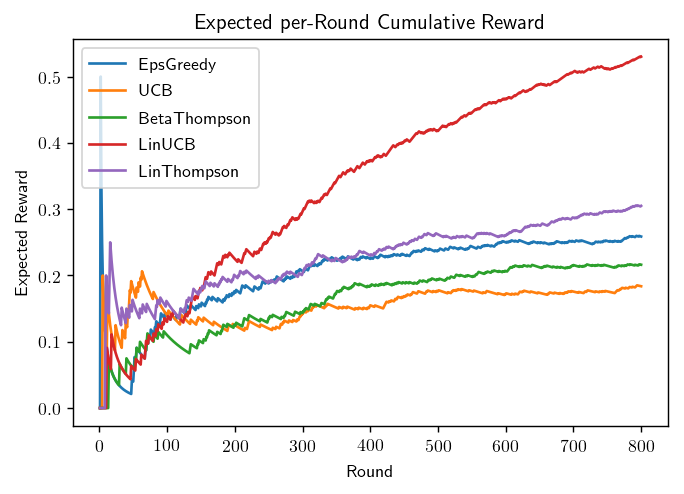

In [27]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

for mab in ['EpsGreedy', 'UCB', 'BetaThompson', 'LinUCB', 'LinThompson']:
    results = eval('results_' + mab)
    tround = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results)/tround
    plt.plot(tround, cumsum, label=mab)
    
plt.legend()
plt.xlabel('Round')
plt.ylabel('Expected Reward')
plt.title('Expected per-Round Cumulative Reward')
plt.show()

In [691]:
from collections import defaultdict  # I'm a tutor so I can do this

N_SAMPLES = 512
cutoff = 910
start = 6
cumsum_d = defaultdict(list)

N_ROUNDS = 1000
mean_runs = lambda x: np.mean(np.vstack([r[:cutoff] for r in cumsum_d[x]]), axis=0)[start:]
std_runs = lambda x: np.std(np.vstack([r[:cutoff] for r in cumsum_d[x]]), axis=0)[start:]

In [692]:
# Takes like 20 minutes on a 24-core machine
for _ in range(N_SAMPLES):
    results_EpsGreedy = offlineEvaluate(EpsGreedy(10, 0.05), arms, rewards, contexts, N_ROUNDS)
    results_UCB = offlineEvaluate(UCB(10, 1.0), arms, rewards, contexts, N_ROUNDS)
    results_BetaThompson = offlineEvaluate(BetaThompson(10, 1.0, 1.0), arms, rewards, contexts, N_ROUNDS)
    results_LinThompson = offlineEvaluate(LinThompson(10, 10, 1.0), arms, rewards, contexts, N_ROUNDS)
    for mabtype in ['EpsGreedy', 'UCB', 'BetaThompson', 'LinUCB', 'LinThompson']:
        results = eval('results_' + mabtype)
        tround = np.arange(1, results.size + 1)
        cumsum = np.cumsum(results)/tround
        cumsum_d[mabtype].append(cumsum)

In [712]:
eps_mean_cumsum, eps_std_cumsum = mean_runs('EpsGreedy'), std_runs('EpsGreedy')
ucb_mean_cumsum, ucb_std_cumsum = mean_runs('UCB'), std_runs('UCB')
bts_mean_cumsum, bts_std_cumsum = mean_runs('BetaThompson'), std_runs('BetaThompson')
lucb_mean_cumsum, lucb_std_cumsum = mean_runs('LinUCB'), std_runs('LinUCB')
lts_mean_cumsum, lts_std_cumsum = mean_runs('LinThompson'), std_runs('LinThompson')

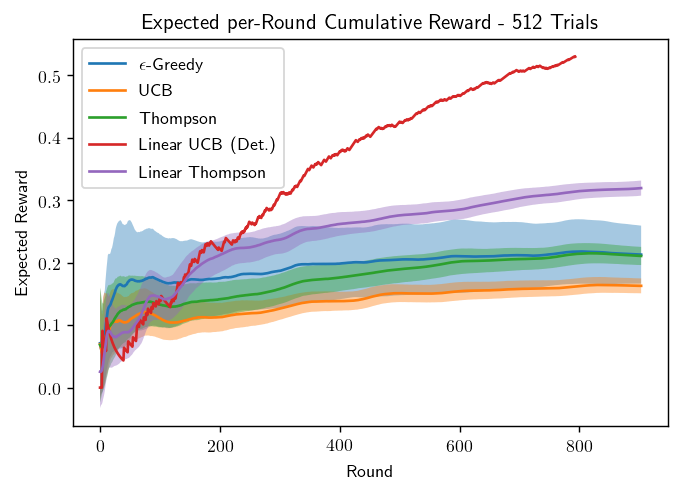

In [713]:
plt.plot(eps_mean_cumsum, label=r'$\epsilon$-Greedy')
plt.plot(ucb_mean_cumsum, label='UCB')
plt.plot(bts_mean_cumsum, label='Thompson')
plt.plot(lucb_mean_cumsum, label='Linear UCB (Det.)')
plt.plot(lts_mean_cumsum, label='Linear Thompson')


plt.fill_between(range(eps_mean_cumsum.size), eps_mean_cumsum-eps_std_cumsum, eps_mean_cumsum+eps_std_cumsum, alpha=0.4)
plt.fill_between(range(ucb_mean_cumsum.size), ucb_mean_cumsum-ucb_std_cumsum, ucb_mean_cumsum+ucb_std_cumsum, alpha=0.4)
plt.fill_between(range(bts_mean_cumsum.size), bts_mean_cumsum-bts_std_cumsum, bts_mean_cumsum+bts_std_cumsum, alpha=0.4)
plt.fill_between(range(lucb_mean_cumsum.size), lucb_mean_cumsum-lucb_std_cumsum, lucb_mean_cumsum+lucb_std_cumsum, alpha=0.4)
plt.fill_between(range(lts_mean_cumsum.size), lts_mean_cumsum-lts_std_cumsum, lts_mean_cumsum+lts_std_cumsum, alpha=0.4)


plt.legend()
plt.xlabel('Round')
plt.ylabel('Expected Reward')
plt.title('Expected per-Round Cumulative Reward - {} Trials'.format(N_SAMPLES))
plt.show()

### 6.B.
Scan over a range of $\alpha$ values in log-space. You may want to reduce granularity and repeat etc. The strategy for $v$ optimization in the `LinThompson` MAB is direectly analagous. If you are feeling fancy then you may want to try gradient-free optimization as the function evaluations here are reasonably cheap. This is typically more effective than simple grid search. See e.g.
* https://github.com/facebookresearch/nevergrad.

In [29]:
import copy

def exp_cum_reward(mab, arms, rewards, contexts, nrounds, nsamples):
    """
    Estimates the expected cumulative reward for a multi-armed bandit using offline evaluation
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int
        number of matching events to evaluate `mab` on.
    
    nsamples : int
        number of samples to use for estimate
    """
    cum_rewards = np.empty(nsamples)
    for i in range(nsamples):
        mab_copy = copy.deepcopy(mab) # Use a copy, since mab can't be reset
        cum_rewards[i] = offlineEvaluate(mab_copy, arms, rewards, contexts, nrounds).sum()
    return {'mean': cum_rewards.mean(), 'stderr': np.std(cum_rewards)/np.sqrt(nsamples)}

In [45]:
alpha_range = np.logspace(-3, 3, num=16)
v_range = np.logspace(-3, 3, num=16)

nrounds = 800
nsamples = 10
narms = 10
ndim = 10

scores_alpha, scores_v = np.zeros_like(alpha_range), np.zeros_like(v_range)
errors_alpha, errors_v = np.zeros_like(alpha_range), np.zeros_like(v_range)

In [46]:
for i, alpha in enumerate(alpha_range):
    mab = LinUCB(narms, ndim, alpha)
    results = exp_cum_reward(mab, arms, rewards, contexts, nrounds, nsamples)
    scores_alpha[i] = results['mean']
    errors_alpha[i] = results['stderr']

print('Best alpha is {}'.format(alpha_range[np.argmax(scores_alpha)]))

for i, v in enumerate(v_range):
    mab = LinThompson(narms, ndim, v)
    results = exp_cum_reward(mab, arms, rewards, contexts, nrounds, nsamples)
    scores_v[i] = results['mean']
    errors_v[i] = results['stderr']

print('Best v is {}'.format(v_range[np.argmax(scores_v)]))

Best alpha is 0.01584893192461114
Best v is 0.00630957344480193


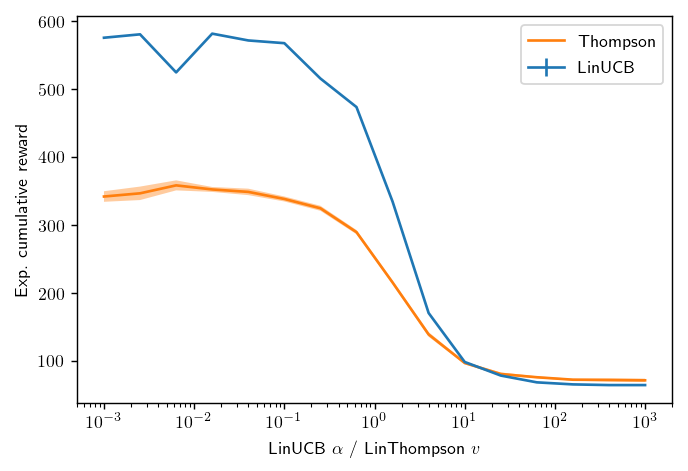

In [47]:
plt.errorbar(alpha_range, scores_alpha, yerr=errors_alpha, label='LinUCB')
plt.plot(v_range, scores_v, label='Thompson')
plt.fill_between(alpha_range, scores_alpha-errors_alpha, scores_alpha+errors_alpha, alpha=0.4)
plt.fill_between(v_range, scores_v-errors_v, scores_v+errors_v, alpha=0.4)

plt.xscale('log')
plt.xlabel(r'LinUCB $\alpha$ / LinThompson $v$')
plt.ylabel('Exp. cumulative reward')
plt.legend()
plt.show()